# Modeling and Predicting Chart Difficulties with Machine Learning

## Business Understanding
### Domain Introduction
Stepmania is an open-source software designed to support many styles of rhythm
game play, but one of its most widely-used formats is for 4-panel “dance games”
(well-known “dance game” examples are Dance Dance Revolution and In The Groove,
but these are specifically-licensed games by Konami and Roxor). The software was
released in 2001 and has since been updated through version 5.3 - the concept behind
this software is to allow players to play a “DDR-like” game with virtually boundless
customizations, including custom charts (arrow patterns for songs).  

### Business Problem
The problem that I aim to solve is using exploratory data analysis and statistical learning
to help establish a standardization for song chart difficulty ratings based on various
features of the chart, for example BPM, duration, and quantity of technical elements.  

### Motivation  
While there are many respectable step-artists with expertise in their domains, there has
not been an official and standardized rating system for song difficulties - it is not
uncommon to see players in conversation over whether a song should be “re-rated”
due to various features of its chart. Creating a method of standardization will help
examine which features are the most important in determining difficulty and help
step-artists remove the intuitive/guesswork element from rating their own charts.
The community of rhythm game players is surprisingly large and the amount of
dedication that this community has poured into creating an open-source rendition of
rhythm games is incredible. This software is free and is used for tournament play and
for writing charts and is a staple to any outside-of-arcade dance game player, and is
sometimes employed in small, local arcades as well.

## A Brief Overview of StepMania and "Dance Games"

### What's the point?  
It's a game and you move your feet really fast!

### Data Acquisition

### Chart Features

See [this link](data/feature_dictionary.txt) for a full explanation of each feature that was extracted from the song files.

## Exploratory Data Analysis

In [170]:
#??? maybe include stepartist in info

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,\
                            roc_curve, auc, classification_report, log_loss, mean_squared_error, mean_squared_log_error
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.decomposition import PCA


from xgboost import XGBClassifier

from statsmodels.graphics.mosaicplot import mosaic

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
##display all dataframe columns
pd.set_option('display.max_columns', None)

In [173]:
not_stam = pd.read_csv('data/not_stam.csv')
stam = pd.read_csv('data/stam.csv')

In [174]:
column_names = not_stam.columns

In [175]:
ordered_features = ['title', 'artist', 'song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg', 'bpm_max', 'bpm_min',\
                    'bpm_mode', 'bpm_change_count', 'song_nps', 'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',\
                    'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands', 'quads', 'holds', 'mines', 'rolls',\
                    'crossovers', 'footswitches', 'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',\
                    'stream_total', 'stream_count', 'stream_size_max', 'stream_size_avg', 'stream_size_std', 'break_count',\
                    'break_size_max', 'break_size_avg', 'break_total', 'break_size_std', 'difficulty', 'rating']

In [176]:
not_stam_df = not_stam[ordered_features]

In [177]:
stam_df = stam[ordered_features]

In [178]:
len(not_stam_df), len(stam_df)

(4808, 2926)

## Non-Stamina EDA

In [179]:
#not_stam_df.isna().sum()

In [180]:
#not_stam_df.info()

In [181]:
non_numeric_cols = ['title', 'artist', 'difficulty']
numeric_cols = list(not_stam_df.columns.drop(non_numeric_cols))

In [182]:
not_stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,4808.000000,4808.000000,4808.000000,4808.000000,4.808000e+03,4808.000000,4808.000000,4808.000000,4808.000000,4.808000e+03,4.808000e+03,4.808000e+03,4.808000e+03,4.808000e+03,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,1773.000000,1773.000000,1773.000000,1531.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,4808.000000
mean,134.433994,477.214434,76.455491,127.731518,8.545380e+04,118.650141,141.624730,8.584027,3.599461,4.686298e+03,2.940412e+03,3.210205e+03,1.416456e+03,3.037067e+03,21.801165,0.183444,0.052413,38.864393,8.481697,3.486897,8.184692,14.552621,3.550333,2.321547,3.410150,4.387895,5.842138,5.820079,5.262831,2.714867,1.792438,6.796954,29.769882,14.492907,65.716864,11.337769,7.497088
std,50.207145,424.772524,30.900622,92.994863,2.886988e+06,43.934407,31.307580,32.944501,3.652527,1.686348e+05,1.056233e+05,1.147700e+05,5.121795e+04,1.076295e+05,25.828948,1.440318,0.741471,41.131565,18.903698,8.686735,9.763098,16.327052,4.165342,3.906833,4.156577,22.516081,16.896380,5.490994,7.135243,3.657608,2.746250,5.480774,16.182127,11.015871,31.639831,9.105002,7.167611
min,4.500124,30.000000,5.000000,-1599.514601,9.000000e+01,-160.000000,47.000000,0.000000,0.216409,4.166667e-01,1.501618e-01,0.000000e+00,8.859642e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000
25%,116.015625,216.000000,63.000000,120.370370,1.280000e+02,86.667000,125.999992,0.000000,1.687649,3.187500e+00,1.715204e+00,1.833333e+00,7.596940e-01,1.666667e+00,5.000000,0.000000,0.000000,10.000000,0.000000,0.000000,2.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,3.000000,18.000000,6.300000,52.000000,5.418223,4.000000
50%,126.792453,440.000000,72.000000,131.268293,1.500000e+02,127.000000,135.000000,0.000000,3.410614,6.002083e+00,3.465543e+00,3.666667e+00,1.439972e+00,3.666667e+00,15.000000,0.000000,0.000000,30.000000,0.000000,0.000000,5.500000,10.000000,2.000000,1.000000,2.000000,0.000000,0.000000,5.000000,3.000000,1.500000,0.816497,6.000000,27.000000,10.857143,62.000000,8.700575,8.000000
75%,139.857286,649.000000,84.000000,153.920280,1.860000e+02,145.000000,157.000000,4.000000,5.025133,9.533333e+00,5.079051e+00,5.333333e+00,2.225257e+00,5.466667e+00,31.000000,0.000000,0.000000,58.000000,9.000000,3.000000,11.000000,20.000000,5.000000,3.000000,5.000000,0.000000,5.000000,8.000000,7.000000,2.500000,2.217356,9.000000,38.000000,19.500000,74.000000,14.302847,10.000000
max,1955.585592,12540.000000,1135.000000,2142.537313,1.000000e+08,300.000000,352.000000,639.000000,132.440785,7.500000e+06,4.598765e+06,5.000000e+06,2.259042e+06,4.583333e+06,676.000000,32.000000,40.000000,1058.000000,343.000000,143.000000,278.000000,459.000000,67.000000,43.000000,95.000000,463.000000,335.000000,140.000000,80.000000,46.500000,24.345431,141.000000,146.000000,89.000000,891.000000,80.610173,420.000000


Some variables to examine:  
`song_seconds` max value of 1955 (that's really long for a non-stamina song)  
`step_count` max value of 12540 (that's also entirely too long)  
`bpm_weighted_avg` min value -1599 (negative weighted averages could throw off the model)  
`bpm_min` min value -160 does not make sense  
`bpm_change_count` of 639 does not make sense in this context  
`rating` value of 420 is most definitely a joke

There was likely a joke chart thrown into one of these packs - the max rating value is 420. So let's take a look at any values that are over 20 because it's extremely unlikely for a technical chart to be playable above that rating.  

First, the ratings:

In [183]:
not_stam_df.loc[not_stam_df['rating'] >= 20]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
770,Deadly force,Noah,110.500000,1084,69,150.000000,150.00,150.00,150.00,0,9.809955,20.000000,9.813512,10.000000,4.143883,10.000000,31,0,0,35,0,0,11,16,0,1,6,1,42,14.0,8.0,3.000000,2.689009,14.0,7.0,1.928571,27.0,1.639150,Edit,21
1408,Weed la Weed,MowtenDoo,99.539591,842,73,176.041477,180.00,173.00,176.00,4,8.458946,12.000000,8.460559,11.733333,4.056128,11.733333,13,0,0,22,0,0,10,3,4,6,3,0,41,2.0,32.0,20.500000,16.263456,3.0,19.0,10.666667,32.0,7.371115,Challenge,420
2016,Speed Complex,Srezcat & Kobaryo,138.750000,988,74,128.000000,128.00,128.00,128.00,0,7.120721,17.066667,7.120721,4.800000,5.549892,4.800000,16,0,0,35,14,1,9,30,2,0,3,0,25,5.0,14.0,5.000000,5.873670,6.0,24.0,8.166667,49.0,9.516652,Easy,20
2792,Do Not Sex To This,The Flashbulb,64.967291,238,36,132.990000,132.99,132.99,132.99,0,3.663382,13.299000,3.663382,3.324750,2.521213,3.324750,0,0,0,107,0,0,8,8,3,0,2,0,2,1.0,2.0,2.000000,NaN,2.0,23.0,17.000000,34.0,8.485281,Hard,69
3664,hot new bonefir remix knife party,PISS SPEARS,96.000000,1342,98,240.061744,243.00,240.00,240.00,4,13.979167,16.000000,13.979167,16.000000,4.052236,16.000000,5,0,0,5,0,0,0,1,0,0,1,0,72,6.0,32.0,12.000000,15.126136,7.0,9.0,3.714286,26.0,3.199702,Challenge,20
3755,HYDRA,96,99.638989,1276,117,277.000000,277.00,277.00,277.00,0,12.806232,18.466667,12.776123,18.466667,6.555248,18.466667,10,0,0,11,0,0,0,0,0,0,0,0,63,5.0,16.0,12.600000,3.974921,6.0,17.0,9.000000,54.0,8.049845,Edit,23
4273,Everyday,Rusko,213.793103,2166,155,174.000000,174.00,174.00,174.00,0,10.131290,17.400000,10.131290,9.425000,6.370936,17.400000,32,0,0,37,17,8,2,35,2,0,1,0,70,22.0,4.0,3.181818,0.394771,23.0,28.0,3.695652,85.0,6.663570,Challenge,22
4274,Everyday,Rusko,213.793103,1374,155,174.000000,174.00,174.00,174.00,0,6.426774,17.400000,6.426774,4.350000,5.289112,3.625000,44,0,0,97,17,8,26,47,2,0,1,0,30,10.0,3.0,3.000000,0.000000,11.0,34.0,11.363636,125.0,14.458719,Hard,20
4275,Everyday,Rusko,213.793103,1374,155,174.000000,174.00,174.00,174.00,0,6.426774,17.400000,6.426774,4.350000,5.289112,3.625000,44,0,0,97,17,8,26,47,2,0,1,0,30,10.0,3.0,3.000000,0.000000,11.0,34.0,11.363636,125.0,14.458719,Medium,20


A lot of these are edits, high step counts, and joke ratings. It's safe to remove them entirely. But first let's look at the tail end most songs with ratings of 18 and higher.

In [184]:
not_stam_df.loc[not_stam_df['rating'] >= 18]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
770,Deadly force,Noah,110.500000,1084,69,150.000000,150.00,150.00,150.00,0,9.809955,20.000000,9.813512,10.000000,4.143883,10.000000,31,0,0,35,0,0,11,16,0,1,6,1,42,14.0,8.0,3.000000,2.689009,14.0,7.0,1.928571,27.0,1.639150,Edit,21
1123,Hay Fields,ICE,146.823529,862,104,170.000000,170.00,170.00,170.00,0,5.870994,22.666667,5.870994,4.958333,3.827461,3.541667,6,0,0,215,58,14,5,57,1,2,7,0,9,8.0,2.0,1.125000,0.353553,9.0,45.0,10.555556,95.0,13.712322,Easy,18
1403,Send My Love To Mars,virt,185.600000,2001,174,225.000000,225.00,225.00,225.00,0,10.781250,15.000000,10.781250,15.000000,4.768360,15.000000,0,0,0,158,0,8,1,6,1,2,4,0,92,5.0,38.0,18.400000,16.682326,6.0,30.0,13.666667,82.0,11.360751,Challenge,18
1408,Weed la Weed,MowtenDoo,99.539591,842,73,176.041477,180.00,173.00,176.00,4,8.458946,12.000000,8.460559,11.733333,4.056128,11.733333,13,0,0,22,0,0,10,3,4,6,3,0,41,2.0,32.0,20.500000,16.263456,3.0,19.0,10.666667,32.0,7.371115,Challenge,420
2016,Speed Complex,Srezcat & Kobaryo,138.750000,988,74,128.000000,128.00,128.00,128.00,0,7.120721,17.066667,7.120721,4.800000,5.549892,4.800000,16,0,0,35,14,1,9,30,2,0,3,0,25,5.0,14.0,5.000000,5.873670,6.0,24.0,8.166667,49.0,9.516652,Easy,20
2792,Do Not Sex To This,The Flashbulb,64.967291,238,36,132.990000,132.99,132.99,132.99,0,3.663382,13.299000,3.663382,3.324750,2.521213,3.324750,0,0,0,107,0,0,8,8,3,0,2,0,2,1.0,2.0,2.000000,NaN,2.0,23.0,17.000000,34.0,8.485281,Hard,69
2914,WANDERLUST,THE QUICK BROWN FOX,128.640000,1305,134,250.000000,250.00,250.00,250.00,0,10.144590,16.666667,10.144590,10.416667,4.724433,8.333333,6,0,0,47,0,9,0,1,0,0,1,0,34,17.0,16.0,2.000000,3.622844,18.0,34.0,5.555556,100.0,8.368163,Challenge,18
2918,18 Pendulum Songs at the Same Time,Pendulum,164.137931,1105,119,174.000000,174.00,174.00,174.00,0,6.732143,11.600000,6.732143,5.800000,3.899841,11.600000,53,0,0,51,16,4,3,12,1,2,2,0,41,2.0,25.0,20.500000,6.363961,3.0,48.0,26.000000,78.0,19.467922,Challenge,18
3663,hot new bonefir remix knife party,PISS SPEARS,96.000000,1121,98,240.061744,243.00,240.00,240.00,4,11.677083,16.000000,11.677083,10.000000,4.213999,16.000000,5,0,0,29,0,0,0,2,0,0,2,0,40,8.0,8.0,5.000000,3.023716,9.0,9.0,6.444444,58.0,3.004626,Hard,18
3664,hot new bonefir remix knife party,PISS SPEARS,96.000000,1342,98,240.061744,243.00,240.00,240.00,4,13.979167,16.000000,13.979167,16.000000,4.052236,16.000000,5,0,0,5,0,0,0,1,0,0,1,0,72,6.0,32.0,12.000000,15.126136,7.0,9.0,3.714286,26.0,3.199702,Challenge,20


This only represents 14 songs out of over 4800. This can be considered safe to drop entirely.

In [185]:
to_drop = not_stam_df.loc[not_stam_df['rating'] >= 18].index

not_stam_df = not_stam_df.drop(to_drop)

In [186]:
not_stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,4794.000000,4794.000000,4794.000000,4794.000000,4.794000e+03,4794.000000,4794.000000,4794.000000,4794.000000,4.794000e+03,4.794000e+03,4.794000e+03,4.794000e+03,4.794000e+03,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,1759.000000,1759.000000,1759.000000,1518.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,4794.000000
mean,134.415241,475.045682,76.353150,127.544427,8.570279e+04,118.437189,141.478246,8.606592,3.584101,4.699936e+03,2.948973e+03,3.219553e+03,1.420579e+03,3.045907e+03,21.809554,0.183980,0.052566,38.780559,8.477472,3.484564,8.187526,14.539841,3.556946,2.325615,3.413016,4.400501,5.735920,5.801023,5.189312,2.673196,1.758797,6.778283,29.801592,14.529166,65.688459,11.354240,7.367751
std,50.211110,422.772163,30.816556,93.034979,2.891197e+06,43.754998,31.142981,32.989810,3.643527,1.688807e+05,1.057773e+05,1.149373e+05,5.129264e+04,1.077865e+05,25.848840,1.442386,0.742548,41.041381,18.912914,8.695793,9.766227,16.315370,4.169098,3.910823,4.160965,22.547726,16.756648,5.484198,7.033156,3.587513,2.676840,5.474604,16.205024,11.039135,31.626062,9.129039,3.852232
min,4.500124,30.000000,5.000000,-1599.514601,9.000000e+01,-160.000000,47.000000,0.000000,0.216409,4.166667e-01,1.501618e-01,0.000000e+00,8.859642e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000
25%,116.015625,215.250000,63.000000,120.358209,1.280000e+02,85.333000,125.439750,0.000000,1.683673,3.187500e+00,1.710209e+00,1.823438e+00,7.574566e-01,1.666667e+00,5.000000,0.000000,0.000000,10.000000,0.000000,0.000000,2.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,3.000000,18.000000,6.300000,52.000000,5.412725,4.000000
50%,126.767013,438.000000,72.000000,131.126178,1.500000e+02,126.000000,135.000000,0.000000,3.401352,6.000000e+00,3.458685e+00,3.666667e+00,1.435628e+00,3.666667e+00,15.000000,0.000000,0.000000,30.000000,0.000000,0.000000,6.000000,10.000000,2.000000,1.000000,2.000000,0.000000,0.000000,5.000000,3.000000,1.500000,0.816497,6.000000,27.000000,10.875000,62.000000,8.713700,8.000000
75%,139.856993,647.750000,84.000000,153.920280,1.860000e+02,145.000000,157.000000,4.000000,5.014260,9.466667e+00,5.060722e+00,5.333333e+00,2.219493e+00,5.437500e+00,31.000000,0.000000,0.000000,58.000000,9.000000,3.000000,11.000000,20.000000,5.000000,3.000000,5.000000,0.000000,5.000000,8.000000,7.000000,2.500000,2.176574,9.000000,38.000000,19.500000,74.000000,14.305094,10.000000
max,1955.585592,12540.000000,1135.000000,2142.537313,1.000000e+08,300.000000,352.000000,639.000000,132.440785,7.500000e+06,4.598765e+06,5.000000e+06,2.259042e+06,4.583333e+06,676.000000,32.000000,40.000000,1058.000000,343.000000,143.000000,278.000000,459.000000,67.000000,43.000000,95.000000,463.000000,335.000000,140.000000,80.000000,46.500000,24.345431,141.000000,146.000000,89.000000,891.000000,80.610173,17.000000


Still some odd values with max `song_seconds`, `step_count`, and `measure_count` - some of these are much more representative of stamina-like data. Let's examine the 90th percentile of both values to see how outlying these values are.

In [187]:
max_seconds = not_stam_df.song_seconds.quantile(.90)
max_step_count = not_stam_df.step_count.quantile(.90)

print(f'90% of non-stamina songs are under {max_seconds} seconds long.')
print(f'90% of non-stamina songs have under {max_step_count} steps.')

90% of non-stamina songs are under 164.00154545454566 seconds long.
90% of non-stamina songs have under 825.6999999999998 steps.


Let's find the songs that have either one.

In [188]:
not_stam_df.loc[(not_stam_df['song_seconds'] > max_seconds) | (not_stam_df['step_count'] > max_step_count)]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
26,Break It Down,JayKode,144.000000,904,90,150.000000,150.000000,150.000000,150.000000,0,6.277778,12.500000,6.277778,6.250000,2.426792,5.625000,66,2,0,41,3,6,11,26,5,0,5,0,10,7.0,4.0,1.428571,1.133893,8.0,24.0,10.000000,80.0,6.546537,Challenge,12
31,Chronos,JAGGS & Dropgun,174.532750,520,60,129.438202,192.000000,64.000000,128.000000,25,2.979384,8.800000,3.176045,2.933333,1.687638,2.666667,50,0,0,40,10,4,7,26,3,0,2,2,1,1.0,1.0,1.000000,NaN,2.0,30.0,29.500000,59.0,0.707107,Challenge,10
32,Chronos,JAGGS & Dropgun,174.532750,369,60,129.438202,192.000000,64.000000,128.000000,25,2.114216,8.800000,2.369335,2.133333,1.706676,2.133333,19,0,0,44,35,0,8,15,3,10,4,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hard,9
33,Chronos,JAGGS & Dropgun,174.532750,238,60,129.438202,192.000000,64.000000,128.000000,25,1.363641,4.800000,1.530605,1.333333,1.152747,1.333333,2,0,0,39,0,0,7,16,4,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Medium,6
34,Chronos,JAGGS & Dropgun,174.532750,161,60,129.438202,192.000000,64.000000,128.000000,25,0.922463,3.200000,1.070202,0.990476,0.782804,1.066667,16,0,0,9,0,0,1,9,1,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Easy,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,Pixel,Tokyo Machine,138.750000,836,74,128.000000,128.000000,128.000000,128.000000,0,6.025225,10.133333,6.025225,6.133333,2.474508,5.333333,18,0,0,74,0,0,25,5,24,43,5,0,17,14.0,2.0,1.214286,0.425815,15.0,20.0,3.800000,57.0,4.783902,Challenge,12
4778,Spider's Blood,"DJ Command feat. Takahito ""Rute"" Koshida",134.634146,865,92,164.000000,164.000000,164.000000,164.000000,0,6.424819,10.933333,6.424819,6.833333,2.356403,7.516667,77,0,0,75,28,0,5,14,0,0,0,0,5,5.0,1.0,1.000000,0.000000,6.0,33.0,14.500000,87.0,10.014989,Challenge,11
4783,Stay the Course,RichaadEB,125.931559,912,69,131.500000,131.500000,131.500000,131.500000,0,7.242029,13.150000,7.242029,7.122917,2.731303,6.027083,20,0,0,62,12,0,7,6,0,0,0,0,32,9.0,7.0,3.555556,2.297341,10.0,7.0,3.700000,37.0,2.162817,Challenge,13
4793,WiFi Tears,Slips & Slurs x Mihka!,145.000827,958,92,152.274994,152.274994,152.274994,152.274994,0,6.606859,15.227499,6.606859,6.344791,4.172929,10.151666,45,0,0,50,4,1,13,3,13,6,1,0,31,11.0,7.0,2.818182,2.040499,12.0,15.0,5.083333,61.0,4.378840,Challenge,14


814 songs. This is a considerable amount of data but it will more accurately represent songs that are 'not stamina'.

In [189]:
to_drop2 = not_stam_df.loc[(not_stam_df['song_seconds'] > max_seconds) | (not_stam_df['step_count'] > max_step_count)].index

not_stam_df = not_stam_df.drop(to_drop2)

Looks like there are a LOT of beginner (level 1) charts, which is interesting. Let's see what's up.

In [190]:
not_stam_df.loc[not_stam_df['rating'] == 1]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
9,666!,Getter & Ghastly,129.414000,73,61,131.043357,192.000000,64.000000,128.000000,73,0.564081,2.133333,0.657622,0.609524,0.548421,0.000000,25,0,0,3,0,0,0,0,0,0,0,16,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
14,99plus,VITICZ & Usica,106.875000,74,57,128.000000,128.000000,128.000000,128.000000,0,0.692398,1.600000,0.692398,0.533333,0.532999,0.533333,18,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
19,Across the Ocean,zircon,114.710154,60,70,165.727483,195.000000,130.000000,195.000000,68,0.523057,1.083333,0.536510,0.541667,0.265213,0.541667,1,0,0,10,0,0,2,5,2,3,2,139,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
30,Break It Down,JayKode,144.000000,91,88,150.000000,150.000000,150.000000,150.000000,0,0.631944,1.250000,0.646307,0.625000,0.306316,0.625000,5,0,0,9,0,0,2,2,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
40,Crew,GoldLink,114.308154,55,65,130.000023,195.000000,86.667000,130.000000,3,0.481156,1.625000,0.500755,0.541667,0.352717,0.541667,1,0,0,6,0,0,0,0,0,1,1,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,Stay the Course,RichaadEB,125.931559,87,68,131.500000,131.500000,131.500000,131.500000,0,0.690851,1.095833,0.701011,0.547917,0.297039,0.547917,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
4792,Swing Break,The McMash Clan feat. Kate Mullins,124.363636,72,56,110.000000,110.000000,110.000000,110.000000,0,0.578947,0.916667,0.589286,0.458333,0.272408,0.458333,3,0,0,0,0,0,4,2,4,5,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
4797,WiFi Tears,Slips & Slurs x Mihka!,145.000827,97,88,152.274994,152.274994,152.274994,152.274994,0,0.668962,1.268958,0.699369,0.634479,0.385276,0.634479,2,0,0,0,0,0,2,17,2,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
4802,Yamatanoorochi,Zekk,100.114286,82,73,175.000000,175.000000,175.000000,175.000000,0,0.819064,1.458333,0.819064,0.729167,0.420022,0.729167,2,0,0,0,0,0,4,6,4,4,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1


In [191]:
not_stam_df.loc[not_stam_df['rating'] == 1].difficulty.value_counts()

Beginner     510
Challenge      2
Medium         1
Hard           1
Name: difficulty, dtype: int64

Not a big deal, but let's drop anything that isn't labelled as 'Beginner' with a rating of 1. These add no value to the data set.

In [192]:
to_drop3 = not_stam_df.loc[(not_stam_df['rating'] == 1) & (not_stam_df['difficulty'] != 'Beginner')].index

not_stam_df = not_stam_df.drop(to_drop3)

In [193]:
not_stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,3976.000000,3976.000000,3976.000000,3976.000000,3.976000e+03,3976.000000,3976.000000,3976.000000,3976.000000,3.976000e+03,3.976000e+03,3.976000e+03,3.976000e+03,3.976000e+03,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,1195.000000,1195.000000,1195.000000,985.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,3976.000000
mean,124.053055,392.016097,71.556087,128.445408,1.032957e+05,119.409224,139.437185,7.128270,3.297006,5.664939e+03,3.554630e+03,3.880836e+03,1.712368e+03,3.671333e+03,19.682847,0.125503,0.044517,35.612676,7.284457,3.057344,7.588531,13.526157,3.459759,2.305584,3.045775,4.068913,2.445171,4.585774,3.067782,1.818037,0.989008,5.564854,30.878661,15.958787,61.855230,12.085204,6.794266
std,15.924041,223.136476,14.453356,91.520214,3.174489e+06,41.727158,29.124917,24.368784,3.747383,1.854303e+05,1.161430e+05,1.262006e+05,5.631914e+04,1.183488e+05,20.354179,1.140272,0.772665,34.662417,17.085499,7.846722,7.777032,14.107452,3.907534,3.835344,3.461547,21.938801,5.403936,3.099138,3.177273,1.716371,1.464348,3.080946,15.481318,10.967610,15.457944,9.297410,3.586828
min,4.500124,30.000000,7.000000,-1599.514601,9.000000e+01,-160.000000,47.000000,0.000000,0.270833,4.166667e-01,1.501618e-01,0.000000e+00,8.859642e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,4.000000,1.555556,14.000000,0.000000,1.000000
25%,114.375000,193.000000,61.000000,120.973881,1.280000e+02,95.000000,125.000000,0.000000,1.580840,2.900000e+00,1.594206e+00,1.650000e+00,7.023809e-01,1.562500e+00,5.000000,0.000000,0.000000,9.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,3.000000,19.000000,7.387500,52.000000,5.862765,4.000000
50%,123.870968,392.000000,70.000000,130.000000,1.450000e+02,128.000000,132.000000,0.000000,3.184235,5.408333e+00,3.224247e+00,3.458333e+00,1.306355e+00,3.437500e+00,13.000000,0.000000,0.000000,27.000000,0.000000,0.000000,5.000000,9.000000,2.000000,1.000000,2.000000,0.000000,0.000000,4.000000,2.000000,1.250000,0.547723,5.000000,29.000000,12.600000,61.000000,9.551863,7.000000
75%,133.928342,576.000000,80.000000,150.000000,1.786250e+02,144.000000,152.000000,3.000000,4.647012,8.533333e+00,4.688511e+00,4.999250e+00,2.030695e+00,5.066216e+00,28.000000,0.000000,0.000000,54.000000,6.000000,2.000000,11.000000,19.000000,5.000000,3.000000,4.000000,0.000000,2.000000,7.000000,4.000000,2.000000,1.253566,8.000000,39.000000,22.500000,71.000000,15.203501,10.000000
max,164.001545,825.000000,160.000000,2142.537313,1.000000e+08,282.991000,352.000000,363.000000,132.440785,7.500000e+06,4.598765e+06,5.000000e+06,2.259042e+06,4.583333e+06,180.000000,32.000000,40.000000,291.000000,236.000000,116.000000,61.000000,145.000000,47.000000,41.000000,28.000000,463.000000,40.000000,16.000000,28.000000,28.000000,11.313708,17.000000,107.000000,60.500000,121.000000,72.124892,16.000000


Now let's address `bpm_weighted_avg` and `bpm_change_count`.

In [194]:
not_stam_df = not_stam_df.drop(not_stam_df.loc[not_stam_df['bpm_weighted_avg'] < 0].index)

In [195]:
max_bpm_avg = round(not_stam_df.bpm_weighted_avg.quantile(.9))

print(f'90% of not-stamina songs have a max bpm weighted average of {max_bpm_avg} or less.')

90% of not-stamina songs have a max bpm weighted average of 174 or less.


In [196]:
not_stam_df = not_stam_df.drop(not_stam_df.loc[not_stam_df['bpm_weighted_avg'] > max_bpm_avg].index)

In [197]:
max_bpm_change = round(not_stam_df.bpm_change_count.quantile(.9))

print(f'90% of not-stamina songs have {max_bpm_change} bpm changes or fewer.')

90% of not-stamina songs have 12 bpm changes or fewer.


In [198]:
not_stam_df = not_stam_df.drop(not_stam_df.loc[not_stam_df['bpm_change_count'] > max_bpm_change].index)

In [199]:
len(not_stam_df)

3109

The columns listed above with NaN values are largely attributed to stamina data as they measure 'streams' and 'breaks' and because technical songs do not contain very large amounts of long continuous streaming, these can be safe to drop as they do not add meaningful value to this data.

In [200]:
cols_to_drop = ['stream_count', 'stream_size_max', 'stream_size_avg', 'stream_size_std', 'break_count', 'break_size_max',\
               'break_size_avg', 'break_total', 'break_size_std']

not_stam_df = not_stam_df.drop(columns = cols_to_drop, axis = 1)

In [201]:
not_stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,rating
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,124.101668,385.119009,69.109360,132.363892,143.605739,123.100819,134.133855,1.048569,3.128115,5.704338,3.151579,3.334811,1.364357,3.453183,19.055323,0.139273,0.054358,34.153426,6.135092,2.730782,7.514957,13.253136,3.437118,2.355098,2.972982,0.644580,2.563204,6.727887
std,14.659893,221.753105,12.139589,19.286544,33.938481,29.355787,21.100654,2.282330,1.813628,3.470732,1.828776,1.942174,0.832852,2.216173,19.861056,1.231647,0.871731,34.294385,14.993620,7.374206,7.784471,14.227013,3.940964,3.984202,3.456278,3.420463,5.598505,3.585407
min,16.971412,30.000000,7.000000,58.741500,90.000000,4.250000,47.000000,0.000000,0.270833,0.441225,0.270833,0.000000,0.094991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,114.375000,188.000000,61.000000,122.000000,125.999992,110.000000,124.999992,0.000000,1.533361,2.708333,1.551966,1.625000,0.672529,1.600000,5.000000,0.000000,0.000000,8.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,123.809524,383.000000,69.000000,130.000000,134.014000,128.000000,130.000000,0.000000,3.107060,5.166667,3.118669,3.312500,1.236158,3.350000,13.000000,0.000000,0.000000,25.000000,0.000000,0.000000,5.000000,9.000000,2.000000,1.000000,2.000000,0.000000,0.000000,7.000000
75%,133.125000,569.000000,76.000000,145.531915,155.000000,142.000000,149.998000,1.000000,4.586449,8.399999,4.612512,4.875000,1.938770,5.000000,28.000000,0.000000,0.000000,51.000000,4.000000,2.000000,11.000000,19.000000,5.000000,3.000000,4.000000,0.000000,2.000000,10.000000
max,163.125000,824.000000,120.000000,174.000000,540.000000,174.000000,212.000000,12.000000,9.154944,34.000000,9.609466,10.656250,7.248217,13.800000,180.000000,32.000000,40.000000,291.000000,211.000000,105.000000,61.000000,145.000000,47.000000,41.000000,25.000000,65.000000,40.000000,16.000000


In [202]:
not_stam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3109 entries, 0 to 4807
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   3109 non-null   object 
 1   artist                  3109 non-null   object 
 2   song_seconds            3109 non-null   float64
 3   step_count              3109 non-null   int64  
 4   measure_count           3109 non-null   int64  
 5   bpm_weighted_avg        3109 non-null   float64
 6   bpm_max                 3109 non-null   float64
 7   bpm_min                 3109 non-null   float64
 8   bpm_mode                3109 non-null   float64
 9   bpm_change_count        3109 non-null   int64  
 10  song_nps                3109 non-null   float64
 11  nps_per_measure_max     3109 non-null   float64
 12  nps_per_measure_avg     3109 non-null   float64
 13  nps_per_measure_median  3109 non-null   float64
 14  nps_per_measure_std     3109 non-null   

No NaN values, no weird extreme values, we should be good! Let's visualize.

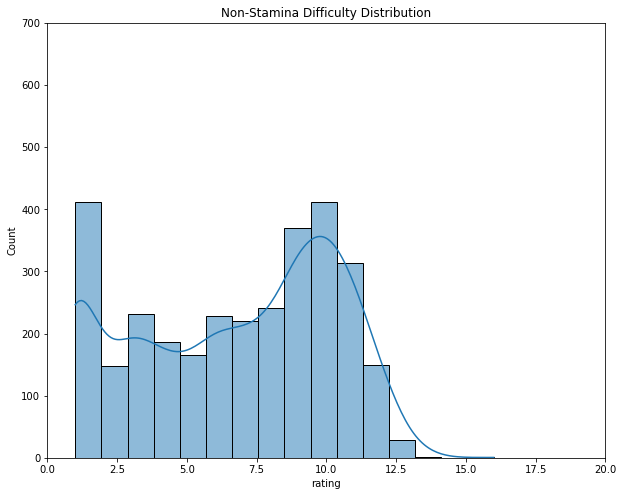

In [203]:
fig, ax = plt.subplots(figsize = (10, 8))
graph = sns.histplot(data = not_stam_df, x = 'rating', kde = True)
graph.set(xlim = (0, 20), ylim = (0, 700))
graph.set(title = "Non-Stamina Difficulty Distribution");

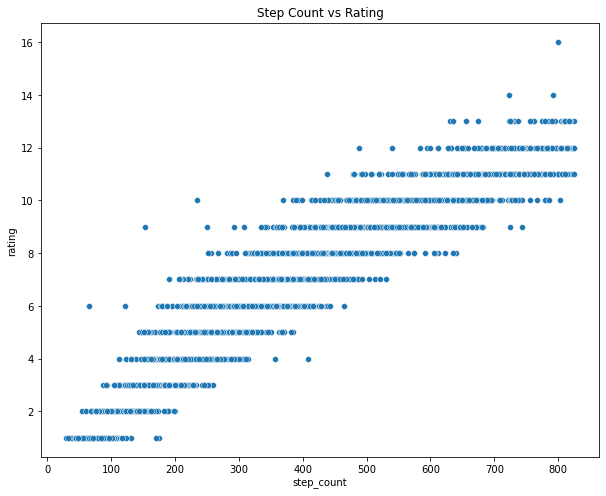

In [204]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = not_stam_df, x = 'step_count', y = 'rating')
steps.set(title = "Step Count vs Rating");

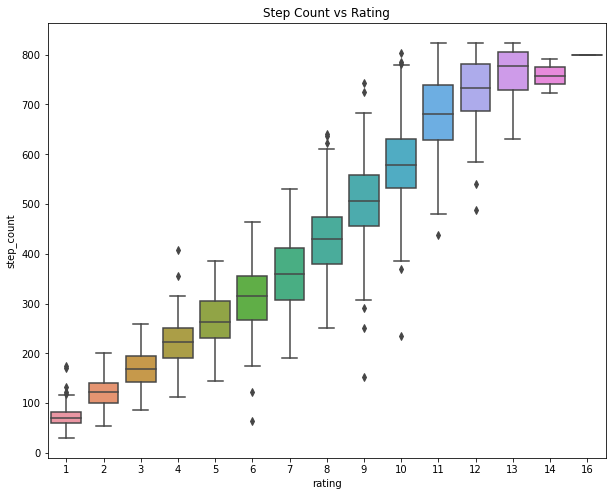

In [205]:
fig, ax = plt.subplots(figsize = (10,8))
step = sns.boxplot(data = not_stam_df, x = 'rating', y = 'step_count')
step.set(title = "Step Count vs Rating");

This is a valuable visualization because you can see how much broader the range is for steps within 8-11 difficulty.

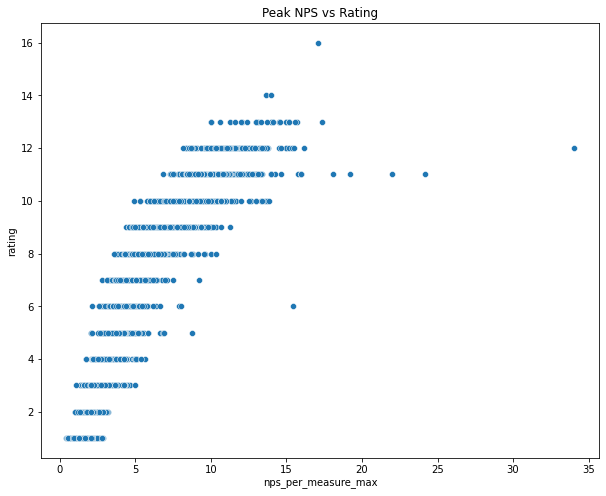

In [206]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = not_stam_df, x = 'nps_per_measure_max', y = 'rating')
steps.set(title = "Peak NPS vs Rating");

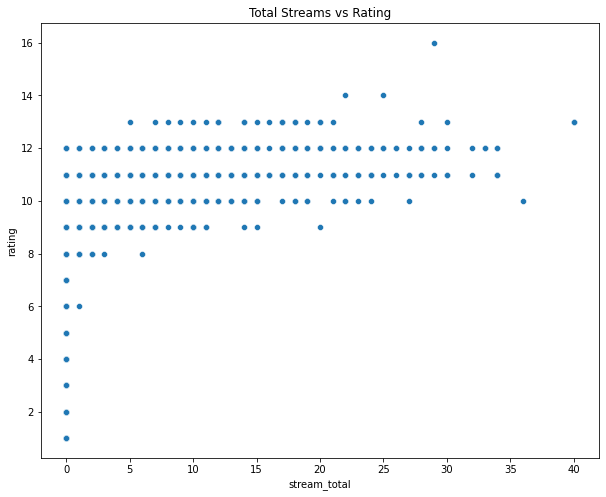

In [207]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = not_stam_df, x = 'stream_total', y = 'rating')
steps.set(title = "Total Streams vs Rating");

In [208]:
not_stam_df.corr()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,rating
song_seconds,1.000000,0.098233,0.496914,-0.067656,-0.059474,-0.118349,-0.049285,0.111097,-0.116081,-0.068599,-0.115329,-0.124162,-0.076792,-0.119753,0.055345,0.000480,-0.012752,0.195787,0.032197,0.077576,0.050799,0.069526,0.069297,0.020802,0.057958,-0.055499,-0.034241,-0.023102
step_count,0.098233,1.000000,0.212970,0.159349,0.118973,0.104387,0.148578,-0.006652,0.969895,0.910816,0.966479,0.951850,0.882131,0.864986,0.557466,0.129608,0.046556,0.507758,0.397978,0.300450,0.475295,0.450030,0.170527,0.002697,0.505757,0.002647,0.613409,0.952948
measure_count,0.496914,0.212970,1.000000,0.719836,0.457039,0.398981,0.726994,0.036574,0.105331,0.151072,0.102377,0.094181,0.140714,0.093977,0.137344,-0.022474,-0.050546,0.188133,0.080860,0.106167,0.047905,0.067005,0.050765,-0.002539,0.054325,-0.038667,-0.029951,0.076861
bpm_weighted_avg,-0.067656,0.159349,0.719836,1.000000,0.534948,0.652667,0.919347,-0.074316,0.176072,0.197578,0.175487,0.167791,0.190115,0.169422,0.097667,-0.001345,0.007718,0.053811,0.039691,0.064867,0.023303,0.031794,0.011523,-0.012662,0.029214,0.001015,-0.005314,0.093083
bpm_max,-0.059474,0.118973,0.457039,0.534948,1.000000,-0.017547,0.553610,0.537870,0.144445,0.232240,0.166170,0.151647,0.238819,0.140182,0.083356,-0.017969,0.010268,0.057850,0.105495,0.059289,0.015433,0.068134,0.039992,-0.005980,0.057321,0.221758,0.001013,0.085076
bpm_min,-0.118349,0.104387,0.398981,0.652667,-0.017547,1.000000,0.485720,-0.568441,0.124864,0.097859,0.111409,0.112408,0.087135,0.111577,0.035627,0.005399,0.021285,0.009900,-0.010354,0.044325,0.023646,-0.001882,-0.005843,0.002279,0.003852,-0.064647,0.028582,0.060380
bpm_mode,-0.049285,0.148578,0.726994,0.919347,0.553610,0.485720,1.000000,0.020981,0.162010,0.192908,0.166906,0.160099,0.188492,0.157983,0.093337,0.000358,0.022395,0.046003,0.026064,0.052987,0.008538,0.018738,-0.006044,-0.036362,0.020815,-0.031273,-0.014232,0.083675
bpm_change_count,0.111097,-0.006652,0.036574,-0.074316,0.537870,-0.568441,0.020981,1.000000,-0.015515,0.048879,0.005217,-0.002253,0.065242,-0.009739,0.010275,-0.007329,0.039102,0.038151,0.073560,0.027943,-0.004758,0.051168,0.038454,0.008435,0.048011,0.263804,-0.038125,0.004997
song_nps,-0.116081,0.969895,0.105331,0.176072,0.144445,0.124864,0.162010,-0.015515,1.000000,0.928380,0.997369,0.984579,0.901936,0.897761,0.540035,0.128513,0.049426,0.452577,0.388356,0.273975,0.459149,0.431111,0.151873,-0.005256,0.488271,0.018385,0.624495,0.953965
nps_per_measure_max,-0.068599,0.910816,0.151072,0.197578,0.232240,0.097859,0.192908,0.048879,0.928380,1.000000,0.935082,0.906715,0.945903,0.803313,0.535718,0.160470,0.100070,0.459028,0.404206,0.288713,0.425259,0.391104,0.134416,0.001773,0.446783,0.057767,0.616910,0.910451


## Stamina EDA

In [209]:
#stam_df.isna().sum()

In [210]:
stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,2926.000000,2926.000000,2926.000000,2926.000000,2.926000e+03,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2535.000000,2535.000000,2535.000000,2449.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2926.000000
mean,288.478922,2168.811347,206.767259,95.135805,7.014561e+03,165.765754,172.792568,2.049897,7.326411,102.399694,17.241969,8.057189,28.674169,9.420610,20.076555,0.093643,0.057758,69.308954,11.993848,3.479494,5.201640,12.503418,3.079631,1.370472,4.185578,0.010595,88.174983,9.392505,30.754635,15.375035,10.028672,10.378453,39.845699,15.941810,111.406867,14.022224,13.221121
std,281.915414,3007.661671,210.489980,2007.431283,1.652309e+05,40.775097,34.768049,16.169283,2.911861,4929.619436,535.026703,3.846674,1375.031132,4.445095,30.308042,1.281604,0.533089,84.899761,47.355819,9.874361,9.546307,20.691362,6.003260,3.479484,6.912153,0.176065,175.218495,11.433906,53.662276,45.550953,13.250906,11.434429,28.889696,16.657728,75.754621,13.007312,4.485111
min,61.286375,20.000000,31.000000,-54098.122537,7.600000e+01,10.000000,76.000000,0.000000,0.106967,0.525000,0.125000,0.000000,0.052933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.500000,1.000000,0.000000,1.000000
25%,190.285714,1105.250000,123.000000,143.000000,1.540000e+02,140.000000,147.000000,0.000000,5.623307,9.466667,5.639084,5.666667,2.341269,5.933333,1.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,4.000000,8.000000,4.218900,2.760262,5.000000,20.000000,6.400000,61.000000,6.680687,11.000000
50%,256.633663,1782.000000,187.000000,174.000000,1.740000e+02,174.000000,174.000000,0.000000,7.413709,11.600000,7.431784,7.306250,3.309423,10.333333,8.000000,0.000000,0.000000,45.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,2.000000,0.000000,58.000000,7.000000,17.000000,9.000000,6.057758,8.000000,32.000000,10.875000,98.000000,10.919238,13.000000
75%,318.297872,2517.250000,234.000000,192.980000,1.960000e+02,190.800000,194.000000,0.000000,9.195520,13.333333,9.215318,11.333333,4.132390,12.542600,25.000000,0.000000,0.000000,94.000000,2.000000,2.000000,7.000000,16.000000,4.000000,1.000000,5.000000,0.000000,112.000000,11.000000,34.000000,16.750000,12.417729,12.000000,50.000000,19.000000,147.000000,16.857491,16.000000
max,7089.862103,73602.000000,5059.000000,2897.960243,4.000000e+06,320.000000,320.000000,623.000000,18.614390,266666.683333,28947.848469,35.933333,74382.100838,52.266667,289.000000,40.000000,9.000000,999.000000,712.000000,112.000000,146.000000,224.000000,63.000000,50.000000,97.000000,4.000000,4269.000000,222.000000,2058.000000,2058.000000,189.787249,223.000000,236.000000,136.000000,1038.000000,161.220346,28.000000


Less weird stuff going on in the stamina data but let's check out a few outliers:  
`bpm_weighted_avg` minimum value  of -54098 and maximum value of 2897  
`bpm_change_count` of 623  

In [211]:
stam_df.loc[stam_df['bpm_weighted_avg'] < 0]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
39,End Boss,The Outside Agency,274.000000,3130,274,-559.107621,240.000,160.0,240.00,8,11.423358,20.000000,11.423358,16.000000,6.251415,16.000000,5,0,0,43,0,0,3,8,2,2,2,0,171,7.0,64.0,24.428571,22.262503,8.0,64.0,12.875000,103.0,21.892187,Easy,21.0
40,End Boss,The Outside Agency,274.000000,2589,274,-559.107621,240.000,160.0,240.00,8,9.448905,16.000000,9.448905,8.000000,5.999324,16.000000,5,0,0,68,0,0,3,8,2,2,2,0,110,4.0,33.0,27.500000,9.678154,5.0,79.0,32.800000,164.0,35.933271,Hard,20.0
41,End Boss,The Outside Agency,274.000000,3120,274,-559.107621,240.000,160.0,240.00,8,11.386861,17.000000,11.386861,16.000000,6.216188,16.000000,5,0,0,60,0,0,3,8,2,2,2,0,171,7.0,64.0,24.428571,22.262503,8.0,64.0,12.875000,103.0,21.892187,Challenge,21.0
692,Destination,ZaG-X Vs. Renard,107.162791,759,96,-385.665666,215.000,135.0,215.00,2,7.082682,14.333333,7.082682,6.270833,4.777719,14.333333,16,1,0,3,0,0,0,1,0,0,1,0,23,2.0,12.0,11.500000,0.707107,3.0,32.0,24.333333,73.0,11.590226,Challenge,15.0
707,to Luv me I *** for u,t+pazolite,266.703551,1958,233,-54.271512,220.000,40.0,219.98,26,7.341485,14.666000,7.638755,7.332667,4.010339,7.332667,65,0,7,246,0,0,12,33,7,0,5,0,36,16.0,8.0,2.250000,1.732051,17.0,36.0,11.588235,197.0,12.344325,Challenge,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,Timberwolf,Muzzy,383.847638,2979,282,-88.440869,590.625,87.5,175.00,8,7.760892,11.666667,7.702793,11.666667,4.619721,11.666667,28,0,0,41,95,17,0,2,0,0,1,0,149,9.0,30.0,16.555556,5.077182,10.0,84.0,13.300000,133.0,25.621389,Challenge,15.0
2922,Timberwolf,Muzzy,383.847638,2625,282,-88.440869,590.625,87.5,175.00,8,6.838651,11.666667,6.787456,7.291667,4.194422,11.666667,42,0,0,74,98,23,1,6,1,0,3,0,87,6.0,15.0,14.500000,0.547723,7.0,84.0,27.857143,195.0,30.470907,Hard,14.0
2923,Timberwolf,Muzzy,383.847638,2401,282,-88.440869,590.625,87.5,175.00,8,6.255086,11.666667,6.208259,6.562500,3.871225,11.666667,42,0,0,86,97,23,1,6,1,0,3,0,59,4.0,15.0,14.750000,0.500000,5.0,97.0,44.600000,223.0,43.798402,Medium,13.0
2924,Timberwolf,Muzzy,383.847638,2216,282,-88.440869,590.625,87.5,175.00,8,5.773124,11.666667,5.729905,6.562500,3.339571,5.833333,83,0,0,86,97,41,1,7,1,0,4,0,15,1.0,15.0,15.000000,NaN,2.0,196.0,133.500000,267.0,88.388348,Easy,12.0


Let's replace all negative weighted averages with the 50% percentile - where the majority of the weighted averages fall.

In [212]:
stam_df.bpm_weighted_avg.describe()

count     2926.000000
mean        95.135805
std       2007.431283
min     -54098.122537
25%        143.000000
50%        174.000000
75%        192.980000
max       2897.960243
Name: bpm_weighted_avg, dtype: float64

In [213]:
stam_df[stam_df['bpm_weighted_avg'] < 0] = 174

Now we'll take a look at the extreme values of weighted averages.

In [214]:
max_bpm_avg = stam_df.bpm_weighted_avg.quantile(.9)
print(f'90% of these stamina songs are under {max_bpm_avg} bpm.')

90% of these stamina songs are under 216.0 bpm.


In [215]:
max_bpm_change = round(stam_df.bpm_change_count.quantile(.9))
print(f'90% of these stamina songs have under {max_bpm_change} bpm changes.')

90% of these stamina songs have under 4 bpm changes.


In [216]:
stam_df.loc[(stam_df['bpm_change_count'] > max_bpm_change) | (stam_df['bpm_weighted_avg'] > max_bpm_avg)]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
23,Alice in Underground,Demetori,375.692308,4822,407,260.000000,260.000,260.0,260.000,0,12.834971,17.333333,12.834971,13.000000,4.407595,17.333333,0,0,0,2,0,0,0,0,0,0,0,0,184,20.0,16.0,9.200000,5.207282,21.0,41.0,10.619048,223.0,10.210172,Hard,23.0
24,Alice in Underground,Demetori,375.692308,5932,407,260.000000,260.000,260.0,260.000,0,15.789517,17.333333,15.789517,17.333333,3.647888,17.333333,0,0,0,2,0,0,0,0,0,0,0,0,339,8.0,85.0,42.375000,21.619683,9.0,26.0,7.555556,68.0,8.748016,Challenge,25.0
25,âˆ€rkadia,Sakuzyo,281.146090,2358,195,165.848032,168.028,126.3,168.028,6,8.387099,16.666700,8.396592,8.333350,5.950581,8.333350,0,0,0,32,25,0,6,14,2,0,2,0,55,4.0,16.0,13.750000,2.061553,5.0,40.0,28.000000,140.0,13.546217,Hard,19.0
26,âˆ€rkadia,Sakuzyo,281.146090,3066,195,165.848032,168.028,126.3,168.028,6,10.905362,16.666700,10.917964,16.666700,6.951766,16.666700,0,0,0,26,25,0,0,2,0,0,2,0,111,5.0,34.0,22.200000,7.224957,6.0,24.0,14.000000,84.0,9.186947,Challenge,22.0
27,Atome Conscient,La Foudre,331.673820,3635,322,233.000000,233.000,233.0,233.000,0,10.959563,15.533333,10.959563,12.620833,5.248596,15.533333,3,0,0,64,1,4,1,2,1,1,0,0,158,28.0,13.0,5.642857,3.211257,29.0,42.0,5.655172,164.0,10.268801,Hard,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,174,174,174.000000,174,174,174.000000,174.000,174.0,174.000,174,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174,174,174,174,174,174,174,174,174,174,174,174,174,174.0,174.0,174.000000,174.000000,174.0,174.0,174.000000,174.0,174.000000,174,174.0
2922,174,174,174.000000,174,174,174.000000,174.000,174.0,174.000,174,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174,174,174,174,174,174,174,174,174,174,174,174,174,174.0,174.0,174.000000,174.000000,174.0,174.0,174.000000,174.0,174.000000,174,174.0
2923,174,174,174.000000,174,174,174.000000,174.000,174.0,174.000,174,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174,174,174,174,174,174,174,174,174,174,174,174,174,174.0,174.0,174.000000,174.000000,174.0,174.0,174.000000,174.0,174.000000,174,174.0
2924,174,174,174.000000,174,174,174.000000,174.000,174.0,174.000,174,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174,174,174,174,174,174,174,174,174,174,174,174,174,174.0,174.0,174.000000,174.000000,174.0,174.0,174.000000,174.0,174.000000,174,174.0


Here, we are going to drop the outliers instead of replacing the data - it is valid data but is not useful to making a meaningful interpretation of 'stamina' songs.

In [217]:
to_drop = stam_df.loc[(stam_df['bpm_change_count'] > max_bpm_change) | (stam_df['bpm_weighted_avg'] > max_bpm_avg)].index
stam_df = stam_df.drop(to_drop)

In [218]:
stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,2411.000000,2411.000000,2411.000000,2411.000000,2.411000e+03,2411.00000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2064.000000,2064.000000,2064.000000,1988.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2411.000000
mean,269.094975,1878.385732,185.133969,165.929504,5.144435e+03,163.55750,165.934886,0.174202,6.976055,10.710988,6.985969,7.611541,3.046910,8.836734,20.173372,0.104936,0.064289,68.732476,10.812526,3.270012,5.201991,12.785566,3.137287,1.386976,4.177934,0.002489,71.442970,8.167636,28.403585,14.392725,9.611497,9.151721,39.300048,16.313587,105.630635,14.032756,12.586064
std,130.191940,1411.016654,95.378646,28.410341,1.410339e+05,31.41931,29.008956,0.699981,2.738277,3.498942,2.734144,3.519875,1.294959,4.042409,30.189701,1.402495,0.565625,77.728110,42.259538,9.003485,9.350763,21.181709,6.149168,3.503522,6.999842,0.049834,85.205305,6.075865,33.574617,21.135917,12.296032,6.070692,28.557048,17.023836,62.935838,12.868225,4.114083
min,61.286375,20.000000,31.000000,9.906467,7.600000e+01,43.50000,76.000000,0.000000,0.106967,0.525000,0.125000,0.000000,0.052933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.500000,1.000000,0.000000,1.000000
25%,193.411765,1069.000000,121.000000,142.000000,1.440000e+02,140.00000,142.000000,0.000000,5.373814,9.204833,5.388968,5.383333,2.255779,5.800000,1.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,4.000000,8.000000,4.000000,2.697209,5.000000,20.000000,6.545455,59.000000,6.627303,11.000000
50%,256.633663,1711.000000,180.000000,174.000000,1.740000e+02,173.80000,174.000000,0.000000,7.102717,11.600000,7.106021,6.900000,3.152498,9.333333,9.000000,0.000000,0.000000,46.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,2.000000,0.000000,53.000000,7.000000,16.000000,8.759615,5.903994,8.000000,32.000000,11.166667,94.000000,10.920982,13.000000
75%,316.497041,2402.000000,225.000000,184.600893,1.857495e+02,182.00000,185.000000,0.000000,8.762662,12.801700,8.768899,10.400000,3.907401,11.666667,26.000000,0.000000,0.000000,96.000000,2.000000,2.000000,7.000000,16.000000,4.000000,1.000000,5.000000,0.000000,103.000000,11.000000,32.000000,16.511364,12.040676,11.500000,49.000000,19.267857,143.500000,17.064337,15.000000
max,1762.105263,20184.000000,1395.000000,216.000000,4.000000e+06,240.00000,240.000000,4.000000,17.259123,21.929833,16.451659,21.929833,8.186705,21.929833,289.000000,40.000000,9.000000,641.000000,501.000000,112.000000,108.000000,224.000000,63.000000,50.000000,97.000000,1.000000,1194.000000,46.000000,512.000000,472.000000,189.787249,47.000000,236.000000,136.000000,531.000000,161.220346,28.000000


In [219]:
stam_df.isna().sum()

title                       0
artist                      0
song_seconds                0
step_count                  0
measure_count               0
bpm_weighted_avg            0
bpm_max                     0
bpm_min                     0
bpm_mode                    0
bpm_change_count            0
song_nps                    0
nps_per_measure_max         0
nps_per_measure_avg         0
nps_per_measure_median      0
nps_per_measure_std         0
nps_per_measure_mode        0
jumps                       0
hands                       0
quads                       0
holds                       0
mines                       0
rolls                       0
crossovers                  0
footswitches                0
crossover_footswitches      0
jacks                       0
invalid_crossovers          0
stop_count                  0
stream_total                0
stream_count              347
stream_size_max           347
stream_size_avg           347
stream_size_std           423
break_coun

To preserve this data, we are going to impute NaNs with the median value:

In [220]:
to_impute = ['stream_count', 'stream_size_max', 'stream_size_avg', 'stream_size_std', 'break_count', 'break_size_max', \
            'break_size_avg', 'break_total', 'break_size_std']

In [221]:
stam_df = stam_df.fillna(0)

In [230]:
stam_df.stream_count = stam_df.stream_count.replace(0, stam_df.stream_count.median())
stam_df.stream_size_max = stam_df.stream_size_max.replace(0, stam_df.stream_size_max.median())
stam_df.stream_size_avg = stam_df.stream_size_avg.replace(0, stam_df.stream_size_avg.median())
stam_df.stream_size_std = stam_df.stream_size_std.replace(0, stam_df.stream_size_std.median())
stam_df.break_count = stam_df.break_count.replace(0, stam_df.break_count.median())
stam_df.break_size_max = stam_df.break_size_max.replace(0, stam_df.break_size_max.median())
stam_df.break_size_avg = stam_df.break_size_avg.replace(0, stam_df.break_size_avg.median())
stam_df.break_total = stam_df.break_total.replace(0, stam_df.break_total.median())
stam_df.break_size_std = stam_df.break_size_std.replace(0, stam_df.break_size_std.median())

In [231]:
stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,2411.000000,2411.000000,2411.000000,2411.000000,2.411000e+03,2411.00000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000
mean,269.094975,1878.385732,185.133969,165.929504,5.144435e+03,163.55750,165.934886,0.174202,6.976055,10.710988,6.985969,7.611541,3.046910,8.836734,20.173372,0.104936,0.064289,68.732476,10.812526,3.270012,5.201991,12.785566,3.137287,1.386976,4.177934,0.002489,71.442970,7.855662,26.618416,13.320270,9.047989,8.841145,37.813355,15.321103,101.931149,13.373456,12.586064
std,130.191940,1411.016654,95.378646,28.410341,1.410339e+05,31.41931,29.008956,0.699981,2.738277,3.498942,2.734144,3.519875,1.294959,4.042409,30.189701,1.402495,0.565625,77.728110,42.259538,9.003485,9.350763,21.181709,6.149168,3.503522,6.999842,0.049834,85.205305,5.672741,31.367378,19.729416,11.142605,5.666022,26.661876,15.931245,58.907870,12.003116,4.114083
min,61.286375,20.000000,31.000000,9.906467,7.600000e+01,43.50000,76.000000,0.000000,0.106967,0.525000,0.125000,0.000000,0.052933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.235702,2.000000,1.000000,0.500000,1.000000,0.500000,1.000000
25%,193.411765,1069.000000,121.000000,142.000000,1.440000e+02,140.00000,142.000000,0.000000,5.373814,9.204833,5.388968,5.383333,2.255779,5.800000,1.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,4.000000,11.000000,4.792857,4.576529,5.000000,22.000000,7.222222,64.000000,7.234931,11.000000
50%,256.633663,1711.000000,180.000000,174.000000,1.740000e+02,173.80000,174.000000,0.000000,7.102717,11.600000,7.106021,6.900000,3.152498,9.333333,9.000000,0.000000,0.000000,46.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,2.000000,0.000000,53.000000,6.000000,16.000000,6.941176,4.627430,7.000000,29.000000,9.437500,80.000000,9.330952,13.000000
75%,316.497041,2402.000000,225.000000,184.600893,1.857495e+02,182.00000,185.000000,0.000000,8.762662,12.801700,8.768899,10.400000,3.907401,11.666667,26.000000,0.000000,0.000000,96.000000,2.000000,2.000000,7.000000,16.000000,4.000000,1.000000,5.000000,0.000000,103.000000,10.000000,32.000000,14.781746,10.067274,11.000000,47.000000,17.600000,133.000000,15.539504,15.000000
max,1762.105263,20184.000000,1395.000000,216.000000,4.000000e+06,240.00000,240.000000,4.000000,17.259123,21.929833,16.451659,21.929833,8.186705,21.929833,289.000000,40.000000,9.000000,641.000000,501.000000,112.000000,108.000000,224.000000,63.000000,50.000000,97.000000,1.000000,1194.000000,46.000000,512.000000,472.000000,189.787249,47.000000,236.000000,136.000000,531.000000,161.220346,28.000000


In [232]:
len(stam_df)

2411

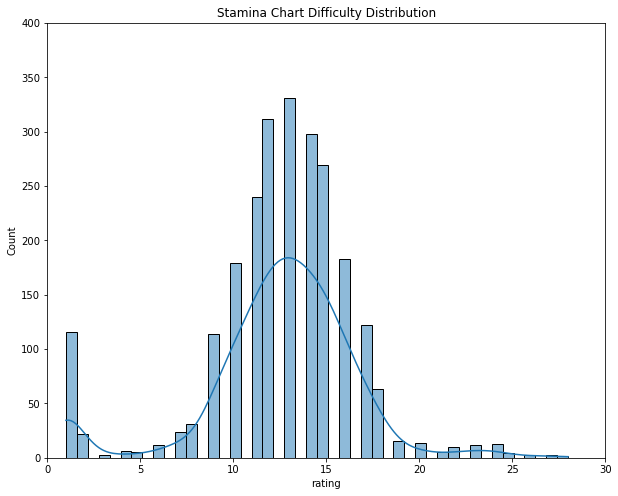

In [236]:
fig, ax = plt.subplots(figsize = (10, 8))
graph = sns.histplot(data = stam_df, x = 'rating', kde = True)
graph.set(xlim = (0, 30), ylim = (0, 400))
graph.set(title = "Stamina Chart Difficulty Distribution");

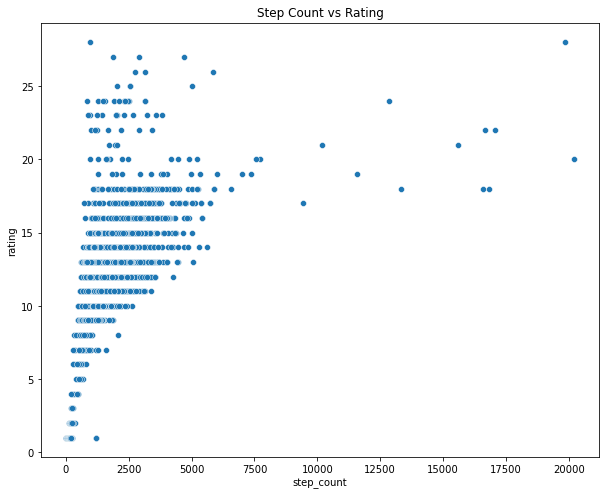

In [237]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = stam_df, x = 'step_count', y = 'rating')
steps.set(title = "Step Count vs Rating");

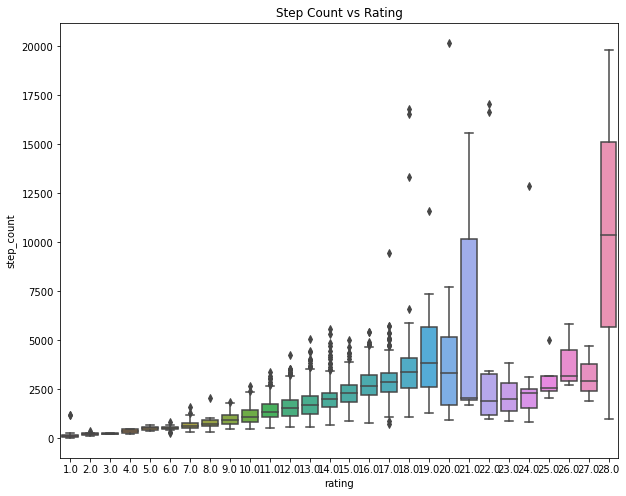

In [238]:
fig, ax = plt.subplots(figsize = (10,8))
step = sns.boxplot(data = stam_df, x = 'rating', y = 'step_count')
step.set(title = "Step Count vs Rating");

In [239]:
stam_df.corr()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
song_seconds,1.000000,0.779640,0.934118,-0.077591,-0.048898,-0.082420,-0.077053,0.044616,0.003267,-0.067032,0.004659,0.036259,-0.038521,0.000511,0.060247,-0.049498,-0.063975,0.147651,0.094490,0.103639,0.061036,0.113846,0.054500,0.023077,0.119653,-0.036663,0.656482,0.267764,0.438643,0.230737,0.363131,0.267192,0.293699,0.161240,0.474105,0.200531,0.075504
step_count,0.779640,1.000000,0.851914,0.202220,-0.029038,0.192009,0.204731,-0.001082,0.559600,0.411858,0.559702,0.536681,0.351003,0.474436,0.057807,-0.031600,-0.032896,0.095242,0.055573,0.056415,-0.004749,0.046517,-0.010020,-0.037582,0.091325,-0.017268,0.930679,0.343415,0.651498,0.409516,0.545647,0.341792,0.044363,-0.050118,0.207015,0.007879,0.574043
measure_count,0.934118,0.851914,1.000000,0.237468,-0.041084,0.212814,0.237822,0.041596,0.171856,0.107284,0.171577,0.178534,0.100805,0.143649,0.120165,-0.044512,-0.045762,0.163891,0.092554,0.095993,0.071502,0.133546,0.074990,0.035374,0.144798,-0.030974,0.732046,0.334441,0.473912,0.248764,0.392184,0.333376,0.266096,0.121365,0.488000,0.169066,0.214543
bpm_weighted_avg,-0.077591,0.202220,0.237468,1.000000,0.042715,0.902281,0.976440,-0.032082,0.456177,0.496869,0.453178,0.383813,0.390115,0.387619,0.166419,0.014339,0.051121,0.062421,-0.052329,0.015497,0.014723,0.054083,0.036257,-0.002307,0.077959,0.027891,0.186399,0.194946,0.101556,0.048331,0.094026,0.193650,0.011546,-0.053186,0.132249,-0.020446,0.375405
bpm_max,-0.048898,-0.029038,-0.041084,0.042715,1.000000,0.041125,0.041654,0.092115,0.014091,0.015354,0.013983,0.008719,0.004441,0.019948,-0.012252,-0.002639,-0.004004,-0.001530,-0.009031,-0.011513,-0.013341,-0.012405,-0.014175,-0.013972,-0.010968,0.706665,-0.021686,0.017529,-0.019799,-0.017108,-0.020910,0.017640,-0.026673,-0.022098,-0.026902,-0.024365,0.000776
bpm_min,-0.082420,0.192009,0.212814,0.902281,0.041125,1.000000,0.902569,-0.304280,0.440941,0.455663,0.430871,0.371256,0.368829,0.367702,0.085977,0.016236,0.054810,0.018022,-0.086311,0.003369,-0.007736,0.021039,0.013143,-0.023256,0.041076,0.028858,0.179210,0.168089,0.107266,0.058300,0.107484,0.166735,-0.004321,-0.066909,0.109614,-0.033180,0.356836
bpm_mode,-0.077053,0.204731,0.237822,0.976440,0.041654,0.902569,1.000000,-0.049608,0.458766,0.494257,0.453748,0.385081,0.385741,0.386339,0.161867,0.015000,0.050045,0.050355,-0.084494,0.013045,0.013880,0.052414,0.039196,-0.011990,0.077147,0.027162,0.189610,0.193385,0.108886,0.054688,0.106358,0.192120,0.010471,-0.054434,0.130088,-0.020978,0.377709
bpm_change_count,0.044616,-0.001082,0.041596,-0.032082,0.092115,-0.304280,-0.049608,1.000000,-0.048915,-0.014105,-0.033661,-0.038869,-0.024845,-0.025393,0.121860,-0.015247,-0.028298,0.098795,0.145403,-0.011746,0.071202,0.094202,0.055463,0.054730,0.090721,0.058938,-0.007340,-0.015923,0.000364,0.006522,-0.007365,-0.016141,0.065597,0.075846,0.042938,0.057859,-0.020481
song_nps,0.003267,0.559600,0.171856,0.456177,0.014091,0.440941,0.458766,-0.048915,1.000000,0.846124,0.999389,0.924472,0.720989,0.875762,0.009745,0.003231,0.020720,-0.031496,-0.021844,-0.019507,-0.090394,-0.057740,-0.086660,-0.109643,0.005390,0.018802,0.594066,0.213290,0.464103,0.379654,0.412094,0.211225,-0.265023,-0.254157,-0.228758,-0.214372,0.927158
nps_per_measure_max,-0.067032,0.411858,0.107284,0.496869,0.015354,0.455663,0.494257,-0.014105,0.846124,1.000000,0.847695,0.715172,0.827772,0.773100,0.167646,0.016270,0.057614,0.136577,0.020478,0.035466,-0.007552,0.047364,-0.018369,-0.055974,0.112555,0.030757,0.346619,0.200201,0.185274,0.140835,0.187159,0.199158,-0.010878,

## Data Understanding - viz goes here instead

# First Simple Model - Linear Regression

In [240]:
data = not_stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1)
target1 = not_stam_df['rating']

In [241]:
X_train, X_test, y_train, y_test = train_test_split(data, target1, random_state = 42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 42)

In [242]:
scaler = StandardScaler()
lr = LinearRegression()

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

lr.fit(X_tr_scaled, y_tr)

LinearRegression()

In [243]:
y_pred = lr.predict(X_tr_scaled)

In [244]:
y_tr[:15]

393     13
3731     4
4062    11
2308     7
392      1
4350     5
668     11
4765     4
1198    11
4493    11
789      4
413     10
3022     2
4037    12
309      6
Name: rating, dtype: int64

In [245]:
y_pred[:15]

array([12.28456394,  3.80737893, 11.67470654,  5.12270344,  1.73011414,
        4.87665578, 11.7913659 ,  4.83788719, 12.34594267, 10.23186238,
        4.25802177,  9.33345538,  1.71884359, 12.50964839,  6.14607826])

In [246]:
lr.score(X_tr_scaled, y_tr)

0.9562792054079913

In [247]:
y_test = lr.predict(X_val_scaled)

In [248]:
y_test[:15].reshape(-1,1)

array([[10.21748474],
       [ 9.08766564],
       [ 9.80337589],
       [11.93605241],
       [ 2.10828334],
       [11.28980475],
       [10.34098579],
       [ 1.99919674],
       [10.044748  ],
       [ 4.01355287],
       [10.64156464],
       [ 1.23880521],
       [ 1.71041524],
       [ 9.73671758],
       [ 1.72849399]])

In [249]:
y_val[:15]

3358    10
3613     8
3421     9
2869    12
3745     2
1289    11
2733    12
2541     2
3502    10
3428     3
4177    10
4797     1
4537     1
879     10
3199     1
Name: rating, dtype: int64

In [250]:
lr.score(X_val_scaled, y_val)

0.9505371065874305

In [251]:
cross_val_score(lr, X_train, y_train)

array([0.94779151, 0.95573119, 0.95630681, 0.94993458, 0.95726081])

In [252]:
lr.coef_

array([ 0.16893247,  1.86129637, -0.57240061,  0.05492288, -0.12741305,
       -0.0666447 ,  0.14099908,  0.02151533,  3.68903678,  0.13340658,
       -2.49469111, -0.15482143,  1.05111217, -0.04179205, -0.18386323,
       -0.0117353 ,  0.01014362,  0.1128374 , -0.0129747 ,  0.04565357,
       -0.10784402,  0.01982558,  0.063774  ,  0.04375378, -0.0115012 ,
        0.02189285, -0.50364637])

## Lasso regression

In [253]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1)

lasso.fit(X_tr_scaled, y_tr)

print(f'LR | Train R^2: {lasso.score(X_tr_scaled, y_tr)} \nLR | Test R^2: {lasso.score(X_val_scaled, y_val)}')
print(f'LR | Val MSE: {mean_squared_error(y_tr, lasso.predict(X_tr_scaled))} \nLR | Val MSE: {mean_squared_error(y_val, lasso.predict(X_val_scaled))}')

LR | Train R^2: 0.8496966921451584 
LR | Test R^2: 0.8526233659172923
LR | Val MSE: 1.9232286806497132 
LR | Val MSE: 1.9564185410554218


In [254]:
lasso.coef_

array([-0.        ,  0.94744962, -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  1.3149951 ,  0.        ,
        0.        ,  0.        ,  0.20837042,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [255]:
cross_val_score(lasso, X_train, y_train, scoring = 'r2')

array([0.92807524, 0.93631635, 0.93156602, 0.92167153, 0.93598831])

In [256]:
lasso.__dict__

{'alpha': 1,
 'l1_ratio': 1.0,
 'fit_intercept': True,
 'normalize': False,
 'precompute': False,
 'max_iter': 1000,
 'copy_X': True,
 'tol': 0.0001,
 'warm_start': False,
 'positive': False,
 'random_state': None,
 'selection': 'cyclic',
 'n_features_in_': 27,
 'n_iter_': 105,
 'coef_': array([-0.        ,  0.94744962, -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  1.3149951 ,  0.        ,
         0.        ,  0.        ,  0.20837042,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]),
 'dual_gap_': 0.20933341632689917,
 'intercept_': 6.691647597254004}

In [257]:
lasso.score(X_val_scaled, y_val)

0.8526233659172923

## Ridge Regression

In [258]:
from sklearn.linear_model import Ridge

ridge = Ridge()

ridge.fit(X_tr_scaled, y_tr)

Ridge()

In [259]:
ridge.score(X_tr_scaled, y_tr), ridge.score(X_val_scaled, y_val)

(0.9560853447742209, 0.9504101029077112)

In [260]:
cross_val_score(ridge, X_train, y_train)

array([0.94749458, 0.95592834, 0.95624723, 0.9500039 , 0.95732461])

In [261]:
ridge_tr_preds = ridge.predict(X_tr_scaled)
ridge_val_preds = ridge.predict(X_val_scaled)

print(f'Ridge | Train R^2: {ridge.score(X_tr_scaled, y_tr)} \nRidge | Test R^2: {ridge.score(X_val_scaled, y_val)}')
print(f'Ridge | Val MSE: {mean_squared_error(y_tr, ridge_tr_preds)} \nRidge | Val MSE: {mean_squared_error(y_val, ridge_val_preds)}')

Ridge | Train R^2: 0.9560853447742209 
Ridge | Test R^2: 0.9504101029077112
Ridge | Val MSE: 0.5619166047405236 
Ridge | Val MSE: 0.6583037719937163


In [262]:
ridge.coef_

array([ 1.44537734e-01,  1.92431576e+00, -5.54865614e-01,  7.67004442e-02,
       -1.48344594e-01, -6.48299214e-02,  1.18871698e-01,  1.82448574e-02,
        2.55842673e+00,  1.21007545e-01, -1.42644677e+00, -1.20664822e-01,
        1.03215098e+00, -6.45319693e-02, -1.81340655e-01, -1.36093685e-02,
        1.25618148e-02,  1.16807934e-01,  1.67243520e-03,  4.59864903e-02,
       -1.06018118e-01,  1.33959407e-02,  6.67167973e-02,  4.15335520e-02,
       -1.14991379e-02,  2.52492954e-02, -4.91578353e-01])

## Elastic Net

In [263]:
from sklearn.linear_model import ElasticNet

net = ElasticNet()

net.fit(X_tr_scaled, y_tr)

ElasticNet()

In [264]:
net.score(X_tr_scaled, y_tr), net.score(X_val_scaled, y_val)

(0.8846552781964115, 0.8852182385725234)

## Plotting residuals

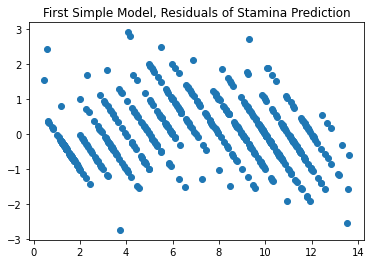

In [459]:
ridge_resids = y_val - ridge_val_preds

plt.scatter(ridge_val_preds, ridge_resids)
plt.title("First Simple Model, Residuals of Stamina Prediction");

hm.

In [266]:
##cross-val score, RMSE
##qqplot, resids

## Polynomial Features

In [267]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_tr_poly = poly.fit_transform(X_tr)
X_val_poly = poly.transform(X_val)

In [268]:
linreg = LinearRegression()

linreg.fit(X_tr_poly, y_tr)
linreg.score(X_tr_poly, y_tr), linreg.score(X_val_poly, y_val)

(0.9771596856799104, -3.6222285112641535)

In [269]:
ridge_2 = Ridge()

ridge_2.fit(X_tr_poly, y_tr)

ridge_2.score(X_tr_poly, y_tr), ridge_2.score(X_val_poly, y_val)

(0.9768374604026127, 0.4811321109216786)

## Let's try a classifier

In [270]:
tree = DecisionTreeClassifier()

In [271]:
tree.fit(X_tr, y_tr)

DecisionTreeClassifier()

In [272]:
tree.score(X_tr, y_tr), tree.score(X_val, y_val)

(1.0, 0.5008576329331046)

In [273]:
tree_preds = tree.predict(X_val)

In [274]:
tree_preds[:15]

array([10, 11, 10, 11,  2, 11, 11,  1, 11,  6, 10,  1,  1, 10,  2],
      dtype=int64)

In [275]:
y_val[:15]

3358    10
3613     8
3421     9
2869    12
3745     2
1289    11
2733    12
2541     2
3502    10
3428     3
4177    10
4797     1
4537     1
879     10
3199     1
Name: rating, dtype: int64

In [276]:
sgd = SGDClassifier()

sgd.fit(X_tr, y_tr)

SGDClassifier()

In [277]:
sgd.score(X_tr, y_tr), sgd.score(X_val, y_val)

(0.41361556064073224, 0.41852487135506006)

## Multiclass with Logistic Regression

In [278]:
set(y_val.values), set(y_tr.values)

({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13},
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16})

In [279]:
clf = LogisticRegression(penalty = 'l2')
scaler = StandardScaler()

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

clf.fit(X_tr_scaled, y_tr)

LogisticRegression()

In [280]:
train_preds = clf.predict(X_tr_scaled)
val_preds = clf.predict(X_val_scaled)

In [281]:
train_preds

array([13,  4, 10, ..., 10,  6,  2], dtype=int64)

In [282]:
y_tr

393     13
3731     4
4062    11
2308     7
392      1
        ..
2505     1
3982    11
3530    10
3994     5
2211     2
Name: rating, Length: 1748, dtype: int64

In [283]:
diffs = y_tr - train_preds

In [284]:
diffs[:20]

393     0
3731    0
4062    1
2308    1
392     0
4350   -1
668     0
4765   -2
1198    0
4493    1
789     0
413     0
3022    1
4037    1
309     0
2081    0
3547    0
2432    0
4       1
1472    0
Name: rating, dtype: int64

In [285]:
y_tr[:20]

393     13
3731     4
4062    11
2308     7
392      1
4350     5
668     11
4765     4
1198    11
4493    11
789      4
413     10
3022     2
4037    12
309      6
2081     3
3547     6
2432     5
4        2
1472     6
Name: rating, dtype: int64

In [286]:
train_preds[:20]

array([13,  4, 10,  6,  1,  6, 11,  6, 11, 10,  4, 10,  1, 11,  6,  3,  6,
        5,  1,  6], dtype=int64)

In [287]:
accuracy_score(y_tr, train_preds)

0.6424485125858124

In [288]:
accuracy_score(y_val, val_preds)

0.5660377358490566

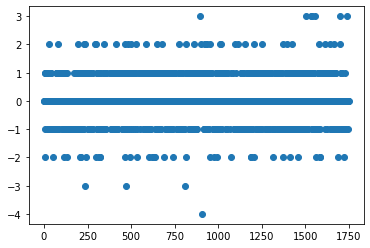

In [289]:
x_ = np.linspace(1, 1748, 1748)
plt.scatter(x_, diffs)

Looks like the majority of errors happened within 1 of the true value, but there are a few very far-off predictions.

## Iterative Model Building

In [290]:
##steps to consider:
#PCA?
#Scaling
#
#Power transform
#Pipeline with a custom transform
#Feature extraction
#Gridsearch

## GridSearching through ridge parameters

In [291]:
ridge_params = {'alpha': [.1, .5, 1, 2, 5, 8],
                'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [292]:
ridge_grid = GridSearchCV(estimator = ridge, param_grid = ridge_params, scoring = 'r2')

In [293]:
ridge_grid.fit(X_tr_scaled, y_tr)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.5, 1, 2, 5, 8],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             scoring='r2')

In [294]:
ridge_grid.best_params_

{'alpha': 0.1, 'solver': 'auto'}

## Using GridSearch params and applying a power transformer

In [298]:
from sklearn.preprocessing import PowerTransformer

power = PowerTransformer()
X_tr_power = power.fit_transform(X_tr)

X_val_power = power.transform(X_val)

X_train_power = power.transform(X_train)

In [299]:
ridge = Ridge(alpha = .1)

ridge.fit(X_tr_power, y_tr)

Ridge(alpha=0.1)

In [301]:
ridge.score(X_tr_power, y_tr), ridge.score(X_val_power, y_val)

(0.965733720016135, 0.9619197253370201)

In [302]:
cross_val_score(ridge, X_train_power, y_train).mean()

0.9639432890034618

improvement!

## Let's add scaling back in

In [304]:
power = PowerTransformer()
scaler = StandardScaler()

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

X_tr_power = power.fit_transform(X_tr_scaled)
X_val_power = power.transform(X_val_scaled)

X_train_power = power.transform(scaler.transform(X_train))

In [305]:
ridge1 = Ridge(alpha = .1)

ridge1.fit(X_tr_power, y_tr)

Ridge(alpha=0.1)

In [306]:
ridge1.score(X_tr_power, y_tr), ridge1.score(X_val_power, y_val)

(0.964640629495855, 0.959806134669476)

In [307]:
cross_val_score(ridge1, X_train_power, y_train).mean()

0.9625299813584253

## PCA??

In [308]:
pca = PCA()
scaler1 = StandardScaler()
power1 = PowerTransformer()


X_tr_pca = pca.fit_transform(X_tr)
X_val_pca = pca.transform(X_val)
X_train_pca = pca.transform(X_train)


X_tr_transformed = power1.fit_transform(scaler1.fit_transform(X_tr_pca))
X_val_transformed = power1.transform(scaler1.transform(X_val_pca))

X_train_transformed = power1.transform(scaler1.transform(X_train_pca))

In [309]:
ridge2 = Ridge(alpha = .1)

ridge2.fit(X_tr_transformed, y_tr)

Ridge(alpha=0.1)

In [310]:
ridge2.score(X_tr_transformed, y_tr), ridge2.score(X_val_transformed, y_val)

(0.9607263287957858, 0.9560815367819756)

In [311]:
cross_val_score(ridge2, X_train_transformed, y_train).mean()

0.9582420513036837

In [312]:
ridge2_preds = ridge2.predict(X_val_transformed)

In [313]:
ridge2_resids = y_val - ridge2_preds

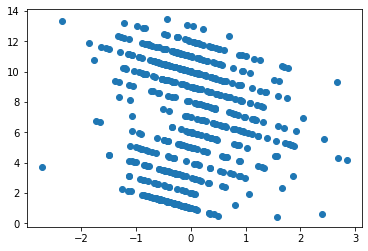

In [314]:
plt.scatter(ridge2_resids, ridge2_preds);

In [315]:
ridge2_preds[:20].reshape(-1,1)

array([[10.30899751],
       [ 9.12307041],
       [ 9.6905756 ],
       [11.87276583],
       [ 2.09909153],
       [11.29308241],
       [10.29640519],
       [ 1.92718395],
       [10.19547858],
       [ 4.04419561],
       [10.61871294],
       [ 1.11112126],
       [ 1.57319777],
       [ 9.75350578],
       [ 1.45631601],
       [ 6.95202153],
       [ 1.06103354],
       [ 1.55105775],
       [11.24757746],
       [ 8.94127986]])

In [316]:
y_val[:20]

3358    10
3613     8
3421     9
2869    12
3745     2
1289    11
2733    12
2541     2
3502    10
3428     3
4177    10
4797     1
4537     1
879     10
3199     1
2393     9
2420     1
2450     1
3335    11
3518     9
Name: rating, dtype: int64

Let's introduce a couple categorical columns and see if this impacts the data at all.

In [323]:
data = not_stam_df.drop(columns = ['title', 'difficulty', 'rating'], inplace = False)
target = not_stam_df['rating']

In [324]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42)

In [325]:
X_train_num = X_train.drop(columns = 'artist', inplace = False)
X_train_cat = X_train[['artist']]

In [326]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
X_train_enc = ohe.fit_transform(X_train_cat)

In [329]:
X_train_enc = pd.DataFrame(X_train_enc,
    columns=ohe.categories_[0],
    index=X_train.index
)

In [331]:
X_train = pd.concat([X_train_num, X_train_enc], axis = 1)

Okay, let's try a ridge regression with encoded and scaled data.

In [350]:
estimators = [('scaler', StandardScaler()), ('power_transformer', PowerTransformer()), ('regressor',Ridge(alpha = .1, solver = 'auto'))]
pipe = Pipeline(estimators)

In [351]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('regressor', Ridge(alpha=0.1))])

In [352]:
cross_val_score(pipe, X_train, y_train)

array([0.95312166, 0.95764847, 0.95863545, 0.9574231 , 0.95755591])

In [353]:
cross_val_score(pipe, X_train, y_train).mean()

0.9568769177860773

In [380]:
pipe.steps[2][1].__dict__

{'alpha': 0.1,
 'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'auto',
 'random_state': None,
 'n_features_in_': 734,
 'coef_': array([ 3.57842613e-01,  9.91310521e-01, -6.48742726e-01, -1.23352398e-01,
        -5.16448875e-02,  1.49900383e-01,  2.62989474e-01, -6.31198249e-03,
         2.98718481e+00,  5.76616222e-01, -1.61744115e+00, -9.00476099e-02,
         1.09655761e+00, -3.94148016e-02, -8.95503972e-02, -4.63571090e-03,
         2.39203103e-02,  1.08427499e-01,  1.36928504e-02,  4.21705278e-02,
        -1.88997363e-02,  1.09915464e-01, -3.07145578e-02,  3.30336124e-02,
         2.80764367e-02,  1.52910088e-02, -3.42567366e-01, -9.30912689e-03,
         1.20649966e-03, -4.35991370e-03, -2.29028582e-02, -4.49987087e-03,
         1.90819628e-03, -1.28936044e-02,  4.51871242e-03,  2.61804368e-04,
        -2.61765921e-03,  4.34802005e-02,  1.03976092e-02,  5.08566829e-02,
         8.06383470e-03, -1.42241818e-02, -1.92101659e

Generally good scores here, but it seems like adding in a very sparse categorical component not only lowered performance but increased computational time considerably! 

### run timeit next time to compare performance.

In [381]:
#back to numerical data only
not_stam_data = not_stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], inplace = False)
not_stam_target = not_stam_df['rating']

In [382]:
X_train_notstam, X_test_notstam, y_train_notstam, y_test_notstam = train_test_split(not_stam_data, not_stam_target, random_state = 42)

In [411]:
estimators = [('scaler', StandardScaler()), ('power_transformer', PowerTransformer()), ('regressor',Ridge(alpha = .3, solver = 'auto'))]
not_stam_pipe = Pipeline(estimators)

In [412]:
not_stam_pipe.fit(X_train_notstam, y_train_notstam)

Pipeline(steps=[('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('regressor', Ridge(alpha=0.3))])

In [413]:
cross_val_score(not_stam_pipe, X_train_notstam, y_train_notstam)

array([0.95837884, 0.96395795, 0.9639744 , 0.95845261, 0.96498783])

In [414]:
cross_val_score(not_stam_pipe, X_train_notstam, y_train_notstam).mean()

0.9619503263716839

In [415]:
not_stam_pipe.steps[2][1].__dict__

{'alpha': 0.3,
 'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'auto',
 'random_state': None,
 'n_features_in_': 27,
 'coef_': array([ 0.22058481,  1.40774478, -0.51067346, -0.10831203, -0.07951302,
         0.02070971,  0.20978554, -0.02668959,  3.07620419,  0.75159909,
        -2.03832982, -0.20742486,  0.98426774, -0.04653715, -0.11645492,
        -0.00743046,  0.01893047,  0.07862088,  0.02785961,  0.02624394,
        -0.05731052,  0.03768056,  0.00660882,  0.04347582,  0.01944834,
         0.07848461, -0.36438262]),
 'n_iter_': None,
 'intercept_': 6.74002574002574}

Coefficients over abs(.75) are indexed as:  
`1, 8, 9, 10, 12`  
corresponding to:  
`step_count`  
`song_nps`  
`nps_per_measure_max`  
`nps_per_measure_avg`   - negative coefficient??   
`nps_per_measure_std`

In [434]:
X_train_notstam.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total'],
      dtype='object')

So far, the most successful approach has been using scaled and power-transformed data for non-stamina estimation.

In [455]:
y_preds_notstam = not_stam_pipe.predict(X_train_notstam)

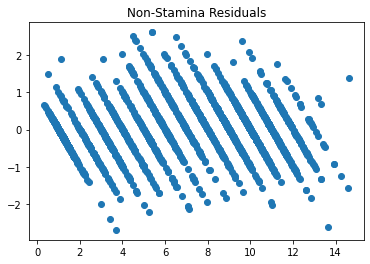

In [458]:
resids = y_train_notstam - y_preds_notstam
plt.scatter(y_preds_notstam, resids)
plt.title("Non-Stamina Residuals");

## Now for stamina data

In [435]:
stam_data = stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1, inplace = False)
stam_target = stam_df['rating']

In [436]:
X_train_stam, X_test_stam, y_train_stam, y_test_stam = train_test_split(stam_data, stam_target, random_state = 1)

In [437]:
estimators = [('scaler', StandardScaler()), ('power_transformer', PowerTransformer()), ('regressor', Ridge(alpha = .3))]
stam_pipe = Pipeline(estimators)

In [438]:
stam_pipe.fit(X_train_stam, y_train_stam)

Pipeline(steps=[('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('regressor', Ridge(alpha=0.3))])

In [439]:
cross_val_score(stam_pipe, X_train_stam, y_train_stam)

array([0.96532997, 0.974713  , 0.97696113, 0.9511203 , 0.95731614])

In [440]:
cross_val_score(stam_pipe, X_train_stam, y_train_stam).mean()

0.9650881063725334

In [441]:
stam_pipe.steps[2][1].__dict__

{'alpha': 0.3,
 'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'auto',
 'random_state': None,
 'n_features_in_': 36,
 'coef_': array([ 0.20972853,  2.14005285, -0.82284947, -0.16558525,  0.03973943,
        -0.01076841,  0.08712364,  0.04162309,  1.54927459,  0.86511665,
         0.30939316, -0.44631496,  1.28093677, -0.08616513,  0.03770322,
         0.01168727,  0.02108856,  0.10412274, -0.08675852,  0.00727017,
         0.1131563 ,  0.02803977, -0.09156847,  0.02943734, -0.02274353,
        -0.04518886, -0.85211144,  0.48139387, -0.07423228,  0.16857627,
         0.14662222, -0.61072362,  0.11669791, -0.13681473, -0.16494886,
        -0.04848232]),
 'n_iter_': None,
 'intercept_': 12.555862831858407}

Coefficients near or over abs(.75) are indexed as:  
`1, 2, 8, 9, 12, 26`  
corresponding to:  
`step_count`  
`measure_count` - negative ?? - possible - longer but less dense   
`song_nps`  
`nps_per_measure_max`  
`nps_per_measure_std`  
`stream_total`

In [442]:
X_train_stam.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total', 'stream_count', 'stream_size_max', 'stream_size_avg',
       'stream_size_std', 'break_count', 'break_size_max', 'break_size_avg',
       'break_total', 'break_size_std'],
      dtype='object')

In [449]:
y_preds_stam = stam_pipe.predict(X_train_stam)

In [450]:
y_train_stam[:20]

1079    13.0
2667    11.0
377     17.0
1733    18.0
1037    14.0
272     14.0
673     10.0
2557     8.0
2892    13.0
1941    16.0
2798    11.0
2336    14.0
2693    10.0
502     18.0
948     15.0
170     18.0
283     12.0
2748    10.0
2813    16.0
289     13.0
Name: rating, dtype: float64

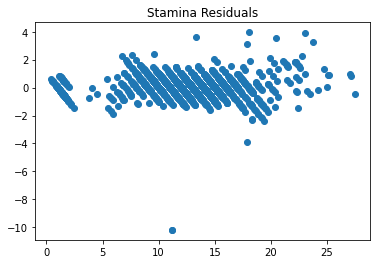

In [454]:
resids = y_train_stam - y_preds_stam
plt.scatter(y_preds_stam, resids)
plt.title("Stamina Residuals");

# Data Explanation

# Final Model

# Summary / Conclusions

# Next Steps